# All Data EDA

Description of data cleaning before this file:

1. Load, combine, clean credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load and clean dataset of earnings call transcripts, dates, year + quarter of statement releases, companies, and sectors (unique key is company by earnings call date).
3. Load and clean tabular financial statement datasets (unique key is company, year, quarter).
4. Load and clean company sector dataset (unique key is company).
5. Use earnings call dates to transform dataset of credit ratings so there is one rating at each fixed quarter date (1/1, 4/1, 7/1, 10/1) for each year. The key assumption is that a rating stays the same until a new rating is issued.
6. Inner join earnings call data with credit rating data, retrieving the most recent earnings call. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data_fixed_quarter` dataset.

GitHub copilot suggestions were used for plotting and low-level syntax.

## Setup - Sample Path and Packages

In [13]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises 4532 earnings calls (transcripts included)
sample = False
# Modify this path as needed to run on your machine
sample_path = r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates_sample.csv'

In [14]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Load and Basic Stats

In [15]:
# Load in sample csv, or full parquet file
# Use inputted sample path, or ~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter.parquet
if sample:
    df = pd.read_csv(sample_path)
else:
    df = pd.read_parquet(r'~\Box\STAT 222 Capstone\Intermediate Data\All_Data\all_data_fixed_quarter_dates.parquet') 
df

,ticker,fixed_quarter_date,earnings_call_date,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,Next Rating,Next Rating Date,...,Change Direction Since Last Fixed Quarter Date,Change Since Last Fixed Quarter Date,Ticker,Description,Company Name,Sector,Industry Group,Industry,Sub-Industry,Comment
0,ABBV,2014-10-01 00:00:00.000000,2014-07-25,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,None,NaN,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,ABBVIE INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d..."
1,ABBV,2015-01-01 00:00:00.000000,2014-10-31,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Same As Last Fixed Quarter Date,0.0,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,ABBVIE INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d..."
2,ABBV,2015-04-01 00:00:00.000000,2015-01-30,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Same As Last Fixed Quarter Date,0.0,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,ABBVIE INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d..."
3,ABBV,2015-07-01 00:00:00.000000,2015-04-23,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Same As Last Fixed Quarter Date,0.0,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,ABBVIE INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d..."
4,ABBV,2015-10-01 00:00:00.000000,2015-07-24,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Same As Last Fixed Quarter Date,0.0,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,ABBVIE INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,ZTS,2015-10-01 00:00:00.000000,2015-08-04,BBB,Standard & Poor's Ratings Services,2015-01-30,Both,7,BBB,2015-11-03,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
4368,ZTS,2016-01-01 00:00:00.000000,2015-11-03,BBB,Standard & Poor's Ratings Services,2015-11-03,Supplementary,7,BBB,2016-01-22,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
4369,ZTS,2016-04-01 00:00:00.000000,2016-02-16,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."
4370,ZTS,2016-07-01 00:00:00.000000,2016-05-04,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Same As Last Fixed Quarter Date,0.0,ZTS,"Zoetis Inc. is focused on the discovery, devel...",ZOETIS INC,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development..."


In [16]:
## summary of the raw data 

# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating Rank AAA is 10,"4,372.00",6.76,1.28,2.00,6.00,7.00,8.00,10.00
credit_rating_year,"4,372.00","2,013.25",1.61,"2,010.00","2,012.00","2,013.00","2,015.00","2,016.00"
days_since_call,"4,372.00",57.45,15.24,0.00,55.00,61.00,67.00,91.00
year,"4,372.00","2,014.09",1.56,"2,010.00","2,013.00","2,014.00","2,015.00","2,019.00"
quarter,"4,372.00",2.49,1.10,1.00,2.00,2.00,3.00,4.00
cik,"4,372.00","707,777.49","549,023.40","1,800.00","75,677.00","833,079.00","1,101,239.00","1,841,666.00"
calendarYear,"4,372.00","2,014.09",1.56,"2,010.00","2,013.00","2,014.00","2,015.00","2,019.00"
period,"4,372.00",2.49,1.10,1.00,2.00,2.00,3.00,4.00
cashAndCashEquivalents,"4,372.00","1,257,519,922.98","2,307,452,658.78",0.00,"132,996,000.00","426,228,500.00","1,317,250,000.00","18,347,000,000.00"
shortTermInvestments,"4,372.00","275,497,324.98","1,203,525,437.74","-515,000.00",0.00,0.00,"18,859,500.00","16,882,000,000.00"


In [17]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [18]:
# Check data is unique on ticker by earnings_call_date
df['ticker_earnings_date'] = df['ticker'] + '_' + df['earnings_call_date'].astype(str)
df['ticker_earnings_date'].value_counts().max()

2

In [19]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

313

## Sector

In [ ]:
# How often is Sector variable missing?
print('Share of missing values for Sector:', df['Sector'].isna().mean())

In [ ]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['Sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Calls in Each Industry Sector')
plt.show()

In [ ]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('Sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
plt.title('Number of Firms in Each Industry Sector')
plt.show()

## Calls

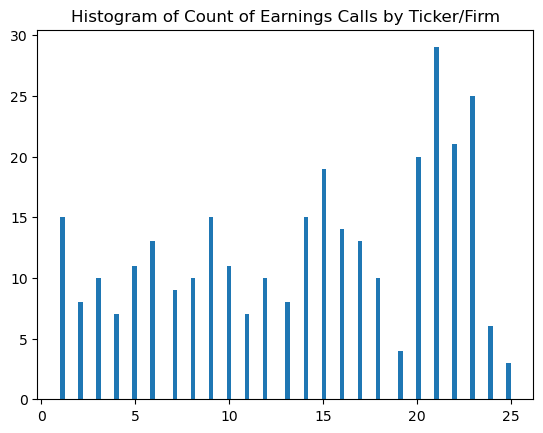

In [20]:
# Histogram of count of earnings calls by ticker/firm
# Title: Histogram of Count of Earnings Calls by Ticker
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Earnings Calls by Ticker/Firm')
plt.show()

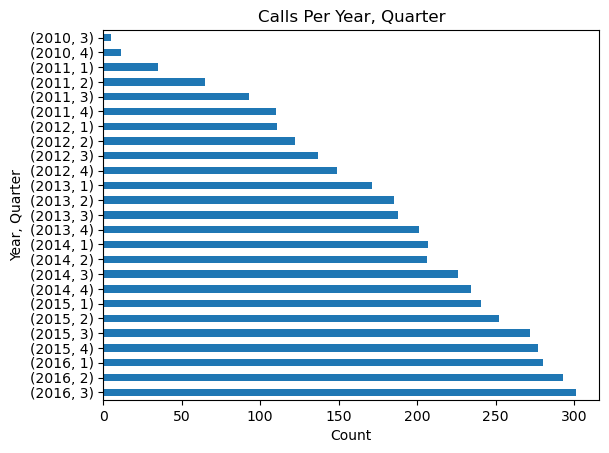

In [24]:
# Distribution of earnings_call_date
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.title('Calls Per Year, Quarter')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.show()


## Overall Dates and Company Dropout

In [25]:
# For each ticker, get the max value of fixed_quarter_date, and print out items where it is not in the last quarter of 2016
# Convert fixed_quarter_date to datetime
df['fixed_quarter_date_dt'] = pd.to_datetime(df['fixed_quarter_date'])
# Add column max_date to df
df['max_date'] = df.groupby('ticker')['fixed_quarter_date_dt'].transform('max')
# Display rows where max_date is not in the last quarter of 2016
df[df['max_date'] < '2016-10-01']

,ticker,fixed_quarter_date,earnings_call_date,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,Next Rating,Next Rating Date,...,Sector,Industry Group,Industry,Sub-Industry,Comment,ticker_earnings_date,call_year,call_quarter,earnings_call_date_dt,max_date
0,ABBV,2014-10-01 00:00:00.000000,2014-07-25,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d...",ABBV_2014-07-25,2014,3,2014-07-25,2016-07-29
1,ABBV,2015-01-01 00:00:00.000000,2014-10-31,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d...",ABBV_2014-10-31,2014,4,2014-10-31,2016-07-29
2,ABBV,2015-04-01 00:00:00.000000,2015-01-30,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d...",ABBV_2015-01-30,2015,1,2015-01-30,2016-07-29
3,ABBV,2015-07-01 00:00:00.000000,2015-04-23,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d...",ABBV_2015-04-23,2015,2,2015-04-23,2016-07-29
4,ABBV,2015-10-01 00:00:00.000000,2015-07-24,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,None,None,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,"Companies primarily engaged in the research, d...",ABBV_2015-07-24,2015,3,2015-07-24,2016-07-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,ZTS,2015-10-01 00:00:00.000000,2015-08-04,BBB,Standard & Poor's Ratings Services,2015-01-30,Both,7,BBB,2015-11-03,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development...",ZTS_2015-08-04,2015,3,2015-08-04,2016-08-03
4368,ZTS,2016-01-01 00:00:00.000000,2015-11-03,BBB,Standard & Poor's Ratings Services,2015-11-03,Supplementary,7,BBB,2016-01-22,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development...",ZTS_2015-11-03,2015,4,2015-11-03,2016-08-03
4369,ZTS,2016-04-01 00:00:00.000000,2016-02-16,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development...",ZTS_2016-02-16,2016,1,2016-02-16,2016-08-03
4370,ZTS,2016-07-01 00:00:00.000000,2016-05-04,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,BBB,2016-12-23,...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Pharmaceuticals,Pharmaceuticals,"Companies engaged in the research, development...",ZTS_2016-05-04,2016,2,2016-05-04,2016-08-03


In [26]:
# Unique firms where this is the case
df[df['max_date'] < '2016-10-01'][['ticker', 'max_date']].drop_duplicates()

,ticker,max_date
0,ABBV,2016-07-29
9,ABC,2016-08-02
32,ABG,2016-07-26
40,ABT,2016-07-20
60,ACHC,2016-07-29
...,...,...
4294,XOM,2016-07-29
4314,XRAY,2016-08-05
4336,XYL,2016-08-02
4337,YUM,2016-07-14


AMCR is amcor, should still exist but it's date is kind of close to the end of 2016

BTU, peabody energy, seems to have gone bankrupt April 13, 2016

FTI underwent a merger in 2016-2017

KBH still exists, but again the date is pretty close...

The other non-close one is STON. Notably, StonMor Partners had some issues with delayed SEC filings https://seekingalpha.com/article/4056108-prelude-to-bankruptcy-saving-grace-stonemor-partners-delays-10-k-again

## Ratings

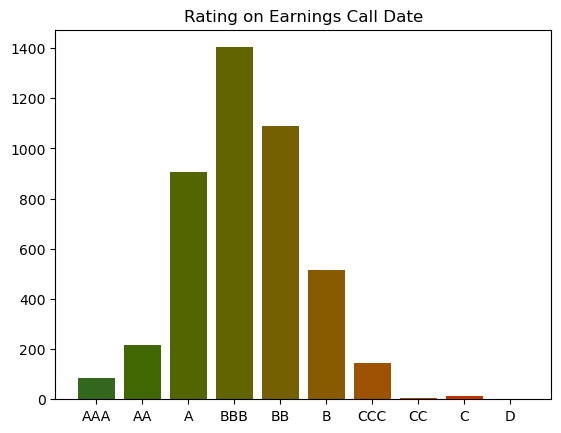

KeyError: 'rating_on_next_earnings_call_date'

In [27]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating Issuances.png')
plt.show()

# Rating on next earnings call date
df['rating_on_next_earnings_call_date'] = pd.Categorical(df['rating_on_next_earnings_call_date'], categories=bar_order, ordered=True)
plt.bar(df['rating_on_next_earnings_call_date'].value_counts().sort_index().index, df['rating_on_next_earnings_call_date'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Next Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating on Next Earnings Call Date.png')
plt.show()

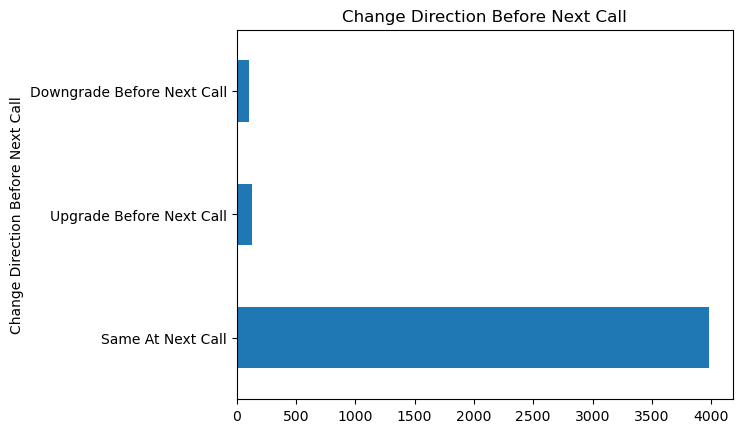

Change Direction Before Next Call
Same At Next Call             3981
Upgrade Before Next Call       130
Downgrade Before Next Call     102
Name: count, dtype: int64


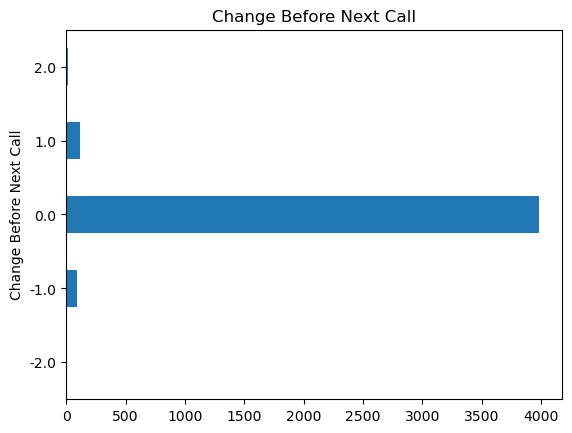

Change Before Next Call
-2.0       9
-1.0      93
 0.0    3981
 1.0     117
 2.0      13
Name: count, dtype: int64


In [ ]:
# Bar chart of 'Change Direction Before Next Call'
df['Change Direction Before Next Call'].value_counts().plot(kind='barh')
plt.title('Change Direction Before Next Call')
plt.show()
print(df['Change Direction Before Next Call'].value_counts())

# Bar chart of 'Change Before Next Call'
df['Change Before Next Call'].value_counts().sort_index().plot(kind='barh')
plt.title('Change Before Next Call')
plt.show()
print(df['Change Before Next Call'].value_counts().sort_index())


In [ ]:
# Value counts of variable Investment_Grade
df['Investment_Grade'].value_counts()

## Financial Statement Data

C:\Users\ijyli\AppData\Local\Temp\ipykernel_11612\3119831694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


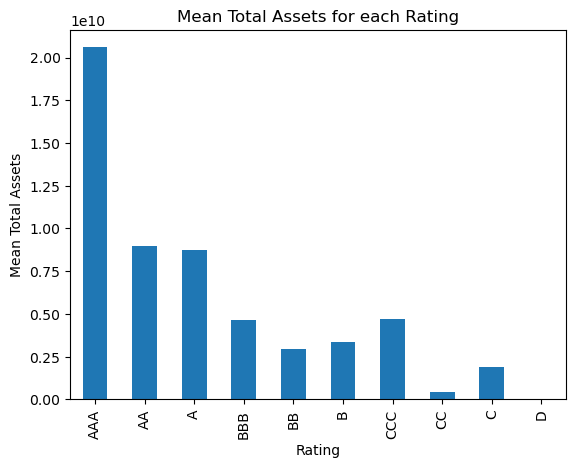

In [ ]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_11612\796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


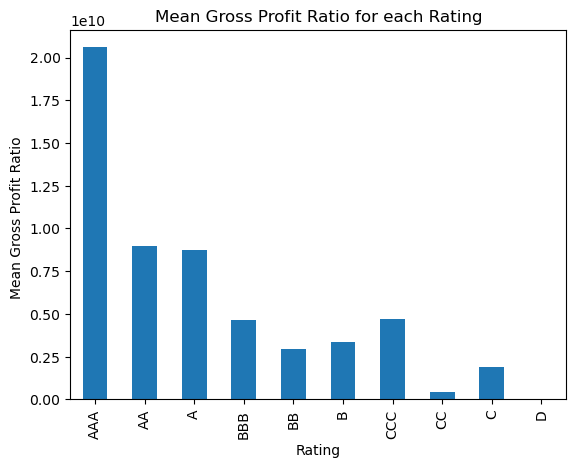

In [ ]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High rating like AAA will have high mean total assets and high mean gross profit ratio.

In [ ]:
# Checking normalized average fianncial value to compare to the graph NN paper's table A.1
# Empty dataframe to store item, count, and percent_of_total_assets
table_a1_replication = pd.DataFrame(columns=['Item', 'Count', 'Percent_of_Total_Assets'])
# Compute average values of: totalAssets, currentLiabilities, totalLiabilities, totalEquity, retainedEarnings, currentAssets, netSales (revenue stand-in), EBIT (ebitda minus depreciation, etc),  market value of equity (commonStock + preferredStock stand-in), workingCapital, and Altman_Z
# Mean of total assets, removing missing and infinite values
total_assets_mean = df['totalAssets'].replace([np.inf, -np.inf], np.nan).dropna().mean()
# Loop over each variable
# Drop missing or infinite values
# Compute count and mean
for variable in ['totalAssets', 'totalCurrentLiabilities', 'totalLiabilities', 'totalEquity', 'retainedEarnings', 'totalCurrentAssets', 'revenue', 'EBIT', 'common_plus_preferred_stock', 'workingCapital']:
    var_count = df[variable].replace([np.inf, -np.inf], np.nan).dropna().count()
    var_mean = df[variable].replace([np.inf, -np.inf], np.nan).dropna().mean()
    table_a1_replication = pd.concat([table_a1_replication, pd.DataFrame({'Item': variable, 'Count': var_count, 'Percent_of_Total_Assets': 100*var_mean/total_assets_mean}, index=[0])])

table_a1_replication

In [ ]:
# Average value of key ratios and altman Z
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
sum_stats_ratios = df[['Ratio_A', 'Ratio_B', 'Ratio_C', 'Ratio_D', 'Ratio_E', 'Altman_Z']].describe().T
sum_stats_ratios